# Introduction

In [1]:
import pandas as pd

import gurobipy as gp

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

In [2]:
# reading data
df = pd.read_csv('price_demand_data.csv')
df.head()

,price,demand
0,1.05,283
1,0.86,771
2,1.21,185
3,0.94,531
4,0.76,1002


In [3]:
# fitting the model
lr = LinearRegression()
lr.fit(df[['price']],df['demand'])

# residuals
res = df['demand'] - lr.predict(df[['price']])
beta1 = lr.coef_[0]
beta0 = lr.intercept_
print(beta0, beta1)

1924.7175435291088 -1367.7125241625981


In [4]:
price = 1

# generating demand
demand = beta0 +  price*beta1 + res
demand[:5]

0    351.385626
1    579.520247
2    472.219630
3    448.937249
4    673.748994
Name: demand, dtype: float64

# Standard NV model - Linear Programming

$$ obj - max (1/n\sum_{i=1}^n (pD_i - qc -t(q- D_i)^+ -g(D_i - q)^+))$$

$$ h_i \le pD_i - qc -t(q- D_i) $$ 
$$ h_i \le pD_i - qc -g(D_i - q) $$

Restructuring above equations, we will get:

Equation 1:
$$ h_i \le pD_i - cq -t(q - D_i)  $$
$$ (c+t)q + h_i \le (p+t)D_i $$

Equation 2:
$$ h_i \le pD_i- cq -g(D_i - q) $$
$$ (c-g)q + h_i \le (p-g)D_i $$

In [17]:
days = len(demand)
p = 1
c = 0.5
g = 0.75
t = 0.15

# objective vetcor
# q, hi (profit of ith day)
# since we need average, divding the coef by number of days
obj = np.array([0] + [1/days] * days)

# We are initializing the constraint matrix
eq = days*2                     # 2 equations per day
var = 1 + days
A = np.zeros((eq, var))                    
b = np.zeros(eq)
sense = np.array(['<'] * eq )

for i in range(days):
    
    # eq 1
    A[2*i,0] = (c+t)
    A[2*i,i+1]=1
    b[2*i] = (p+t)*demand[i]
    
    # eq 2
    A[2*i+1,0] = (c-g)
    A[2*i+1,i+1]=1
    b[2*i+1] = (p-g)*demand[i]

# setting lower bounds fo decsion variables
# quantity >= 0
# profit - (-Infinity, Infinity)
lb = [0] + [-np.inf]*days

In [11]:
opModel = gp.Model()

opModX = opModel.addMVar(len(obj), lb = lb)

opModCon = opModel.addMConstrs(A, opModX, sense, b)
opModel.setMObjective(None, obj, 0, sense=gp.GRB.MAXIMIZE)

opModel.Params.OutputFlag = 0
opModel.optimize()  

print("Optimal quantity to produce - ", round(opModX.x[0]))
print("Profit at optimal quantity- $", round(opModel.objVal, 2))

Optimal quantity to produce -  472
Profit at optimal quantity- $ 231.48


# Model with price as a function of demand - QP

$$ obj fxn= max (1/n\sum_{i=1}^n (pD_ip - qc -t(q- D_i)^+ -g(D_i - q)^+))$$
where $ D_i = \beta_0 + \beta_1p + \hat\epsilon_i$

rewritting the equations we get:
$$ obj fxn= max (p\beta_0 + \beta_1p^2 + \hat\epsilon_ip+ 1/n\sum_{i=1}^n h_i)$$
where $ \hat\epsilon = 1/n\sum_{i=1}^n \epsilon_i$ and $h_i$ is negative cost of each day

s.t.
$$ h_i \le - qc -t(q- D_i) $$
$$ h_i \le - qc -g(D_i - q) $$

Restructuring above equations, we get: 

$$ h_i \le - qc -t(q- (\beta_0 + \beta_1p + \epsilon_i)) $$
$$ h_i + (-t\beta_1)p + (c+t)q\le t(\epsilon_i + \beta_0) $$

$$ h_i \le - qc -g(\beta_0 + \beta_1p + \epsilon_i - q) $$
$$ h_i + (g\beta_1)p + (c-g)q\le -g(\epsilon_i + \beta_0) $$

In [18]:
p = 1
c = 0.5
g = 0.75
t = 0.15

# average residual
epsilon = res.mean()

# objective vetcor
# p, q, hi (profit of ith day)
# since we need average, divding the coef by number of days
lin = np.array([beta0+epsilon] + [0] + [1/days] * days)

# only p^2 has non-zero coef
sigma = np.zeros(shape = (len(lin), len(lin)))
sigma[0,0] = beta1

# We are initializing the constraint matrix
eq = days*2 # 2 equations per day
var = 2 + days
A = np.zeros((eq, var))                    
b = np.zeros(eq)
sense = np.array(['<'] * eq )

for i in range(days):
    # eq 1
    A[2*i,0] = -t*beta1 # p
    A[2*i,1] = c+t      # q
    A[2*i,i+2]=1        # hi
    b[2*i] = t*(res[i]+beta0)
    
    # eq 2
    A[2*i+1,0] = g*beta1  # p
    A[2*i+1,1] = c-g      # q
    A[2*i+1,i+2]=1        # hi
    b[2*i+1] = -g*(res[i]+beta0)


# setting lower bounds fo decsion variables
# price >= 0
# quantity >= 0
# profit - (-Infinity, Infinity)
lb = [0]*2 + [-np.inf]*days

In [16]:
qModel = gp.Model()
opMod_x = qModel.addMVar(var, lb = lb)
opMod_con = qModel.addMConstrs(A, opMod_x, sense, b)
qModel.setMObjective(sigma, lin, 0, sense=gp.GRB.MAXIMIZE)

qModel.Params.OutputFlag = 0
qModel.optimize()  

print("Optimal Price - $", round(qModel.x[0], 2))
print("Optimal Quanity - ", round(qModel.x[1]))
print("Profit at optimal price and quantity - $", round(qModel.objVal, 2))

Optimal Price - $ 0.95
Optimal Quanity -  535
Profit at optimal price and quantity - $ 234.42


# Understanding the sensitivity of the model

In [19]:
# resampling the demand
temp_df = df.sample(len(df), replace=True).reset_index(drop=True)

# refitting the model and getting beta estimates
lr = LinearRegression()
lr.fit(temp_df[['price']],temp_df['demand'])
res = temp_df['demand'] - lr.predict(temp_df[['price']])
beta1 = lr.coef_[0]
beta0 = lr.intercept_

p = 1
c = 0.5
g = 0.75
t = 0.15

# average residual
epsilon = res.mean()

# objective vetcor
# p, q, hi (profit of ith day)
# since we need average, divding the coef by number of days
lin = np.array([beta0+epsilon] + [0] + [1/days] * days)

# only p^2 has non-zero coef
sigma = np.zeros(shape = (len(lin), len(lin)))
sigma[0,0] = beta1

# We are initializing the constraint matrix
eq = days*2  # 2 equations per day
var = 2 + days
A = np.zeros((eq, var))                    
b = np.zeros(eq)
sense = np.array(['<'] * eq )

for i in range(days):
    # eq 1 
    A[2*i,0] = -t*beta1 # p
    A[2*i,1] = c+t      # q
    A[2*i,i+2]=1        # hi
    b[2*i] = t*(res[i]+beta0)
    
    # eq 2
    A[2*i+1,0] = g*beta1  # p
    A[2*i+1,1] = c-g      # q
    A[2*i+1,i+2]=1        # hi
    b[2*i+1] = -g*(res[i]+beta0)

# setting lower bounds fo decsion variables
# price >= 0
# quantity >= 0
# profit - (-Infinity, Infinity)
lb = [0]*2 + [-np.inf]*days

qModel = gp.Model()
opMod_x = qModel.addMVar(var, lb = lb)
opMod_con = qModel.addMConstrs(A, opMod_x, sense, b)
qModel.setMObjective(sigma, lin, 0, sense=gp.GRB.MAXIMIZE)

qModel.Params.OutputFlag = 0
qModel.optimize()  

print("Optimal Price - $", round(qModel.x[0], 2))
print("Optimal Quanity - ", round(qModel.x[1]))
print("Profit at optimal price and quantity - $", round(qModel.objVal, 2))

Optimal Price - $ 0.94
Optimal Quanity -  562
Profit at optimal price and quantity - $ 232.83


# Understanding the sensitivity of the model - simulations

In [21]:
profit = []     # list of profits
quantity = []   # list of quantity
price = []      # list of price

p = 1
c = 0.5
g = 0.75
t = 0.15

# running the simulation 1000 times
for i in range(1000):
    # resampling the demand
    temp_df = df.sample(len(df), replace=True).reset_index(drop=True)
    
    # refitting the model and getting beta estimates
    lr = LinearRegression()
    lr.fit(temp_df[['price']],temp_df['demand'])
    res = temp_df['demand'] - lr.predict(temp_df[['price']])
    beta1 = lr.coef_[0]
    beta0 = lr.intercept_

    # average residual
    epsilon = res.mean()

    # objective vetcor
    # p, q, hi (profit of ith day)
    # since we need average, divding the coef by number of days
    lin = np.array([beta0+epsilon] + [0] + [1/days] * days)
    
    # only p^2 has non-zero coef
    sigma = np.zeros(shape = (len(lin), len(lin)))
    sigma[0,0] = beta1

    # We are initializing the constraint matrix
    eq = days*2  # 2 equations per day
    var = 2 + days
    A = np.zeros((eq, var))                    
    b = np.zeros(eq)
    sense = np.array(['<'] * eq )

    for i in range(days):
        
        # eq 1
        A[2*i,0] = -t*beta1 # p
        A[2*i,1] = c+t      # q
        A[2*i,i+2]=1        # hi
        b[2*i] = t*(res[i]+beta0)
        
        # eq 2
        A[2*i+1,0] = g*beta1  # p
        A[2*i+1,1] = c-g      # q
        A[2*i+1,i+2]=1        # hi
        b[2*i+1] = -g*(res[i]+beta0)

        
    # setting lower bounds fo decsion variables
    # price >= 0
    # quantity >= 0
    # profit - (-Infinity, Infinity)
    lb = [0]*2 + [-np.inf]*days

    qModel = gp.Model()
    opMod_x = qModel.addMVar(var, lb = lb)
    opMod_con = qModel.addMConstrs(A, opMod_x, sense, b)
    qModel.setMObjective(sigma, lin, 0, sense=gp.GRB.MAXIMIZE)

    qModel.Params.OutputFlag = 0
    qModel.optimize()  

    profit = profit + [qModel.objVal]
    price = price + [qModel.x[0]]
    quantity = quantity + [qModel.x[1]]

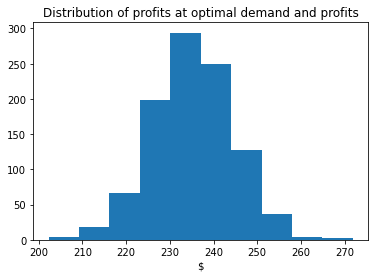

In [30]:
plt.hist(profit)
plt.title("Distribution of profits at optimal demand and profits")
plt.xlabel("$")
plt.show()

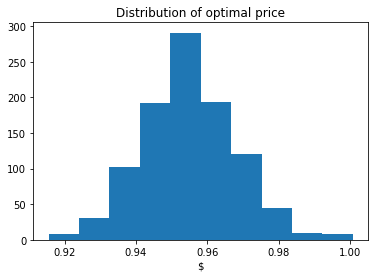

In [31]:
plt.hist(price)
plt.title("Distribution of optimal price")
plt.xlabel("$")
plt.show()

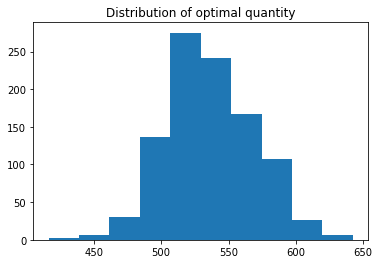

In [33]:
plt.hist(quantity)
plt.title("Distribution of optimal quantity")
plt.show()

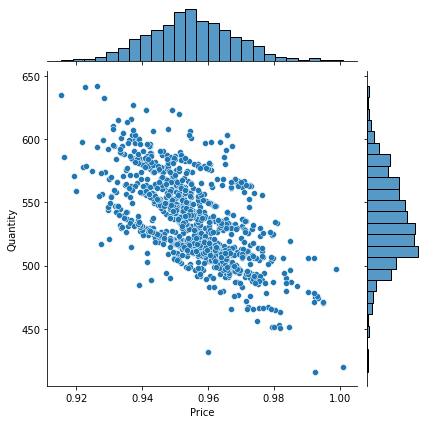

In [38]:
sns.jointplot(data = pd.DataFrame({
    'Price':price,
    'Quantity':quantity
}),
              x = 'Price', y = 'Quantity')
plt.show()

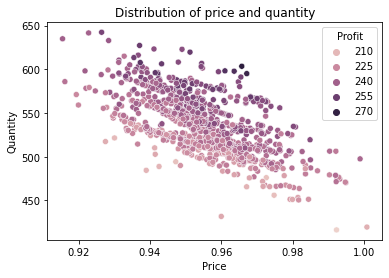

In [40]:
sns.scatterplot(data = pd.DataFrame({
    'Price':price,
    'Quantity':quantity,
    'Profit':profit
}),
              x = 'Price', y = 'Quantity', hue = 'Profit')
plt.title("Distribution of price and quantity")
plt.show()